In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

from lightkurve import search_lightcurvefile
from altaipony.flarelc import FlareLightCurve
from altaipony.fakeflares import aflare

import os
import copy

import numpy as np
import pandas as pd

#from funcs.custom_detrending import custom_detrending, iteratively_remove_sines
from funcs.helper import read_custom_aperture_lc
from funcs.multiperiod import find_period, fetch_lightcurve, remove_sinusoidal

from altaipony.lcio import from_path

#import astropy.units as u

from scipy import optimize
from scipy.misc import derivative

CWD = "/".join(os.getcwd().split("/")[:-2])

import warnings
warnings.simplefilter("ignore")

import pytest

/usr/lib64/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [34]:
lcs = pd.read_csv(f"{CWD}/data/summary/lcs.csv")
lcs

,ID,QCS,typ,cadence_min,mission,prefix,origin,h_mission,SpT,view_start,...,J,R,Gaia_G,vsini_kms,e_vsini_kms,Prot_d,sini,Ref,identifier,Rstar
0,100004076,14,slc,1,kep,KIC,generic,Kepler,L1,1356.50,...,13.078,NaN,17.8356,11.2,2.2,0.370150,>.59,Gizis+13,WISEP J190648.47+401106.8,0.107
1,212035340,18,llc,30,ktwo,EPIC,generic,K2,M8,3437.00,...,15.900,NaN,19.5667,NaN,NaN,0.193000,NaN,Paudel+19,MASS J08371832+2050349,0.111
2,237880881,1,slc,2,tess,TIC,generic,TESS,M5,1331.00,...,11.530,NaN,14.9796,14.4,2.6,0.351250,NaN,Kraus+14,2MASS J01180670-6258591,0.199
3,44984200,10,slc,2,tess,TIC,custom,TESS,M6,1587.25,...,10.309,15.08,14.4115,NaN,NaN,0.113000,NaN,this work,SCR J0838-5855,NaN
4,277539431,12,slc,2,tess,TIC,custom,TESS,M7,1641.00,...,10.630,NaN,14.7381,NaN,NaN,0.190000,NaN,this work,WISEA J105515.71-735611.3,NaN
5,300741820,8,slc,2,tess,TIC,generic,TESS,M6,1522.00,...,11.959,NaN,15.3277,NaN,NaN,0.132000,NaN,Zhan+19,UCAC4 116-015389,NaN
6,230120143,16,slc,2,tess,TIC,generic,TESS,M7,1741.00,...,9.854,NaN,13.5570,10.8,0.7,0.378325,0.6844128,Kesseli+2018,NaN,NaN


In [35]:
target = lcs.loc[2]
target


ID                           237880881
QCS                                  1
typ                                slc
cadence_min                          2
mission                           tess
prefix                             TIC
origin                         generic
h_mission                         TESS
SpT                                 M5
view_start                        1331
view_stop                       1333.5
view_min                           560
view_max                           700
BJDoff                         2457000
tstart                          1331.7
ampl_min                           NaN
ampl_max                           NaN
RA                              19.528
Dec                           -62.9831
J                                11.53
R                                  NaN
Gaia_G                         14.9796
vsini_kms                         14.4
e_vsini_kms                        2.6
Prot_d                         0.35125
sini                     

In [30]:
flcks = search_lightcurvefile(f"{target.prefix} {target.ID}", cadence="short")

RemoteServiceError: Thread was being aborted.

In [16]:
flcks

SearchResult containing 3 data products.

 target_name            productFilename                        description              distance
------------- ------------------------------------ ------------------------------------ --------
kplr100004076 kplr100004076-2012211050319_slc.fits Lightcurve Short Cadence (CSC) - Q14      0.0
kplr100004076 kplr100004076-2012242122129_slc.fits Lightcurve Short Cadence (CSC) - Q14      0.0
kplr100004076 kplr100004076-2012277125453_slc.fits Lightcurve Short Cadence (CSC) - Q14      0.0

In [36]:
flcks = ["/home/ekaterina/.lightkurve-cache/mastDownload/TESS/tess2018206045859-s0001-0000000237880881-0120-s/tess2018206045859-s0001-0000000237880881-0120-s_lc.fits",
        "/home/ekaterina/.lightkurve-cache/mastDownload/TESS/tess2018234235059-s0002-0000000237880881-0121-s/tess2018234235059-s0002-0000000237880881-0121-s_lc.fits"]

10% (1972/20076) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
10% (1972/20076) of the cadences will be ignored due to the quality mask (quality_bitmask=175).


TIC 237880881 modulation period:  8.431534500702735 h
Relative amplitude of modulation: -1.3e-02


Found 9 candidate(s) in the (0,9223) gap.
Found 1 candidate(s) in the (9223,15240) gap.
Found 0 candidate(s) in the (15240,18104) gap.
7% (1420/19737) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
7% (1420/19737) of the cadences will be ignored due to the quality mask (quality_bitmask=175).


TIC 237880881 modulation period:  8.431127617918143 h
Relative amplitude of modulation: -1.3e-02


Found 0 candidate(s) in the (0,9226) gap.
Found 3 candidate(s) in the (9226,18316) gap.


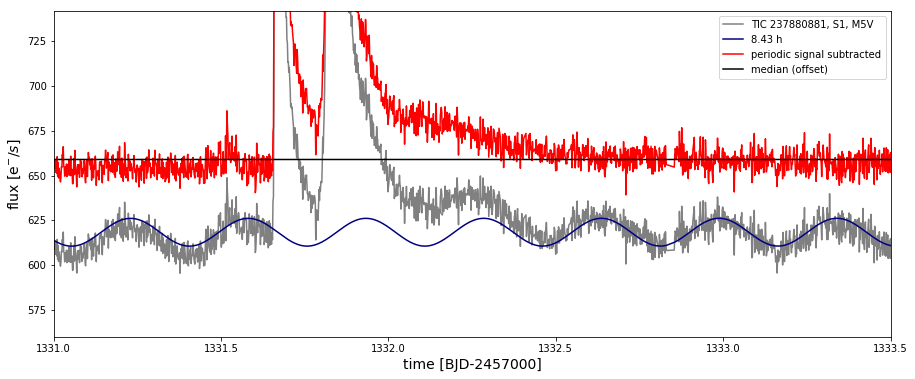

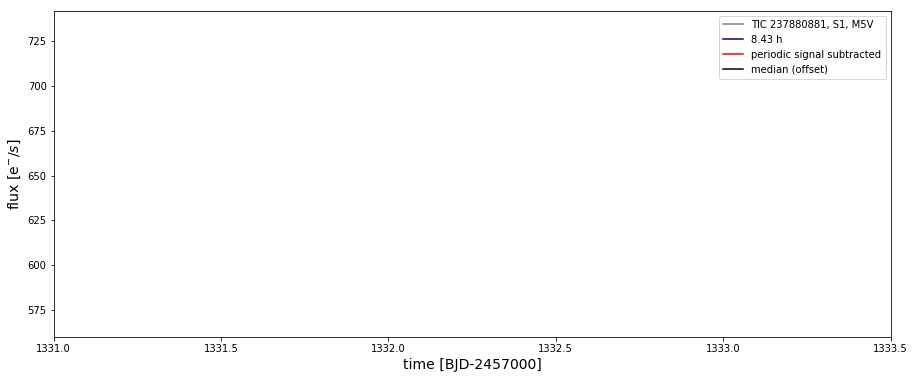

In [37]:
df = pd.DataFrame()
obst = 0
for flck in flcks:
    #flc = flck.download().get_lightcurve("PDCSAP_FLUX")
    flc = from_path(flck, mode="LC", mission="TESS")
    t, sflux, model, period = remove_sinusoidal(target, save=False, flc=flc, custom=False)
    f = FlareLightCurve(time=t.byteswap().newbyteorder(), 
                        detrended_flux=sflux.byteswap().newbyteorder(), 
                        detrended_flux_err=flc.flux_err.byteswap().newbyteorder())
    f = f[np.isfinite(f.detrended_flux)]
    df = df.append(f.find_flares().flares)
    obst += len(t)

In [39]:
#flc = flcks[1].download().get_lightcurve("PDCSAP_FLUX")
flc = from_path(flcks[0], mode="LC", mission="TESS")

10% (1972/20076) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
10% (1972/20076) of the cadences will be ignored due to the quality mask (quality_bitmask=175).


In [14]:
flc.plot()
plt.xlim(1330,1335)

NameError: name 'flc' is not defined

In [41]:
df["obst"] = obst/30#in hours
df = df[(df.tstart<target.tstart-.1) | (df.tstart>target.tstart+1)]
df

,ampl_rec,cstart,cstop,ed_rec,ed_rec_err,istart,istop,total_n_valid_data_points,tstart,tstop,obst
7,0.091343,NaN,NaN,32.667510,2.343163,5837,5842,18104.0,1333.702498,1333.709442,1214.0
8,0.156995,NaN,NaN,53.085504,2.303296,6056,6061,18104.0,1334.008058,1334.015002,1214.0
9,0.196059,NaN,NaN,84.391025,3.043830,9585,9595,18104.0,1340.166476,1340.180365,1214.0
0,0.168640,NaN,NaN,204.141630,3.817886,13710,13726,18316.0,1374.919217,1374.941439,1214.0
1,0.082226,NaN,NaN,23.452383,1.805876,16793,16796,18316.0,1379.335811,1379.339978,1214.0
2,0.231297,NaN,NaN,205.880743,4.417268,17820,17839,18316.0,1380.796895,1380.823283,1214.0


In [44]:
df.to_csv(f"{CWD}/analysis/results/flarefind/{target.ID}_all_flares_short_cadence.csv", index=False)

In [43]:
1214/24

50.583333333333336

In [ ]:
plt.scatter(df.tstop-df.tstart, df.ampl_rec)
plt.scatter([0.74424276547], [1.5470349624552])
plt.yscale("log")
plt.xscale("log")
plt.ylim(.05,2)
plt.xlim(5e-3,1)
plt.xlabel("time [d ]")
plt.ylabel("rel. amplitude")
plt.savefig(f"{CWD}/analysis/results/flarefind/{target.ID}_all_flares_short_cadence.png", dpi=300)

In [7]:
paths = !ls  /work1/eilin/MultiperiodFlares/MalachiteMountains/analysis/results/flarefind/100004076_all_flares_short_cadence.csv
paths

['/work1/eilin/MultiperiodFlares/MalachiteMountains/analysis/results/flarefind/100004076_all_flares_short_cadence.csv']

In [8]:
df = pd.DataFrame()
for p in paths:
    df = df.append(pd.read_csv(p))

In [9]:
df

,ampl_rec,cstart,cstop,ed_rec,ed_rec_err,istart,istop,total_n_valid_data_points,tstart,tstop,obst
0,0.174344,NaN,NaN,28.217183,2.739708,17774,17777,34810.0,1286.439913,1286.441957,2183.716667
1,0.513504,NaN,NaN,66.208411,2.593851,19523,19526,34810.0,1287.631219,1287.633263,2183.716667
2,0.314439,NaN,NaN,541.160553,10.484210,25342,25390,34810.0,1298.539559,1298.572253,2183.716667
3,0.461198,NaN,NaN,63.294333,2.660600,26688,26691,34810.0,1299.456360,1299.458403,2183.716667
4,2.492002,NaN,NaN,852.909193,5.947938,30803,30832,34810.0,1302.268060,1302.287813,2183.716667
5,0.329423,NaN,NaN,51.183135,3.059037,34595,34599,34810.0,1304.859751,1304.862476,2183.716667
6,3.347052,NaN,NaN,2963.498660,9.426482,34701,34782,34810.0,1304.931951,1304.987122,2183.716667
7,0.453494,NaN,NaN,119.782884,3.933160,24818,24826,44148.0,1323.111112,1323.117242,2183.716667
8,1.557639,NaN,NaN,765.604917,7.120177,43936,43966,44148.0,1336.166037,1336.186471,2183.716667
9,0.391471,NaN,NaN,383.795356,7.840932,43978,44004,44148.0,1336.194644,1336.212353,2183.716667


Text(0, 0.5, 'rel. amplitude')

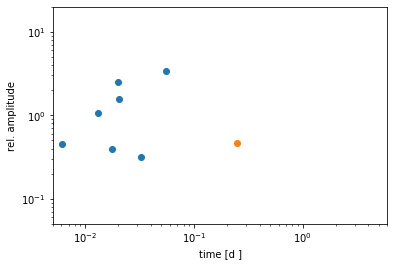

In [13]:
plt.scatter(df.tstop-df.tstart, df.ampl_rec)
plt.scatter([0.25],[.46])
plt.yscale("log")
plt.xscale("log")
plt.ylim(.05,20)
plt.xlim(5e-3,6)
plt.xlabel("time [d ]")
plt.ylabel("rel. amplitude")
#plt.savefig(f"{CWD}/analysis/results/flarefind/all_flares_short_cadence.png", dpi=300)